In [1]:
import numpy as np
import pandas as pd

In [3]:
# https://www.kaggle.com/datasets/shubh0799/churn-modelling

In [20]:
df = pd.read_csv('archive_churn_modelling/Churn_Modelling.csv')

# ДЕЛЕНИЕ НА ВЫБОРКИ

In [21]:
from sklearn.model_selection import train_test_split

# чтобы избегать неравносмерности доли целевого параметра нужно задавать startify

train, test = train_test_split(df, train_size = 0.6, random_state = 42, stratify = df['Exited'])

In [22]:
val, test = train_test_split(test, train_size = 0.5, random_state = 42, stratify = test['Exited'])

# ЧЕЛОВЕЧЕСКОЕ ОБУЧЕНИЕ НА ДВУХ ФИЧАХ

In [23]:
# в человеческом обучении val не нужен, поэтому соединяем с train чтобы данных было больше
train_val = pd.concat([train, val])

In [24]:
train_val.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
6851,6852,15779103,Cantamessa,527,Germany,Female,39,9,96748.89,2,1,0,94711.43,0
7026,7027,15588123,Horton,677,France,Female,27,2,0.00,2,0,1,114685.92,0
5705,5706,15698703,Doherty,628,Germany,Male,40,5,181768.32,2,1,1,129107.97,0


In [25]:
# так как Age переменная непрерывная - делим ее на группы:
train_val['age_group'] = pd.cut(train_val['Age'], [0, 31, 35, 40, 46, 99])

In [26]:
# получаем модель
model = train_val.groupby(['NumOfProducts', 'age_group'])['Exited'].agg('mean').reset_index()
model

,NumOfProducts,age_group,Exited
0,1,"(0, 31]",0.106774
1,1,"(31, 35]",0.135908
2,1,"(35, 40]",0.198646
3,1,"(40, 46]",0.378873
4,1,"(46, 99]",0.542506
5,2,"(0, 31]",0.029293
6,2,"(31, 35]",0.031206
7,2,"(35, 40]",0.059977
8,2,"(40, 46]",0.106239
9,2,"(46, 99]",0.225869


In [27]:
# Переименовываем колонки, чтобы не было повторных названий типо Exited_x, Exited_y
model.columns = ['NumOfProducts', 'age_group', 'score_prod_age']

In [28]:
model

,NumOfProducts,age_group,score_prod_age
0,1,"(0, 31]",0.106774
1,1,"(31, 35]",0.135908
2,1,"(35, 40]",0.198646
3,1,"(40, 46]",0.378873
4,1,"(46, 99]",0.542506
5,2,"(0, 31]",0.029293
6,2,"(31, 35]",0.031206
7,2,"(35, 40]",0.059977
8,2,"(40, 46]",0.106239
9,2,"(46, 99]",0.225869


In [29]:
# Мёржим модель к train_val

train_val = pd.merge(train_val, model, how = 'left', on = ['NumOfProducts', 'age_group'])

In [30]:
train_val.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,age_group,score_prod_age
0,6852,15779103,Cantamessa,527,Germany,Female,39,9,96748.89,2,1,0,94711.43,0,"(35, 40]",0.059977
1,7027,15588123,Horton,677,France,Female,27,2,0.00,2,0,1,114685.92,0,"(0, 31]",0.029293
2,5706,15698703,Doherty,628,Germany,Male,40,5,181768.32,2,1,1,129107.97,0,"(35, 40]",0.059977


In [31]:
# Считаем метрику log_loss:
    
from sklearn.metrics import log_loss

# теперь ошибка log_loss для модели с двумя параметрами:
print(log_loss(train_val['Exited'], train_val['score_prod_age']))

0.3866695862492173


In [32]:
# Функция для uplift:

# функция принмает df, определенный столбец со SCORE и pct - это сколько процентов выборки мы берем:
def uplift(df, score, pct):
    # посчитаем сколько всего в выборке отточных клиентов:
    exited_all = df['Exited'].sum()
    
    # отсортируем df по SCORE:
    df_sorted = df.sort_values(by = score, ascending = False)
    
    
    # теперь надо взять топ-20% этой отсортированной выборки:

    # получаем количество записей которые будут соответствовать pct % всей выборки:
    sorted_20 = round(len(df) * pct)
    
    # посчитаем сколько отточников нашлось в этих сортированных по score_prod строках:
    exited_found = df_sorted.head(sorted_20)['Exited'].sum()
    
    return (exited_found / exited_all) / pct 

In [33]:
# Считаем метрику uplift:

uplift(train_val, 'score_prod_age', 0.2)

2.684049079754601

In [34]:
# проверка модели на тесте:

# Добавляем к test age_group:
test['age_group'] = pd.cut(test['Age'], [0, 31, 35, 40, 46, 99])

# Мёржим модель к test:
test = pd.merge(test, model, how = 'left', on = ['NumOfProducts', 'age_group'])

In [35]:
# Считаем метрику log_loss на тесте:
    
from sklearn.metrics import log_loss

# теперь ошибка log_loss для модели с двумя параметрами:
print(log_loss(test['Exited'], test['score_prod_age']))

0.3870707514157596


In [36]:
# Считаем метрику uplift на тесте:

uplift(test, 'score_prod_age', 0.2)

2.7518427518427515

# МАШИННОЕ ОБУЧЕНИЕ НА ДВУХ ФИЧАХ

In [37]:
from catboost import CatBoostClassifier

In [42]:
# обучимся на тех фичах, на которых делали человеческое обучение:

X = ['NumOfProducts', 'Age']
y = ['Exited']
# не задаем список категориальных фичей, потому что все выбранные фичи - числовые.

In [43]:
# создаем параметры: 'learning_rate': сначала не задавали, потом 0.03, потом - 0.01 (добиваемся конечной итерации ближе к 998)

params = {'verbose':100,
         'random_seed': 42,
         'learning_rate': 0.01}

In [44]:
# создаем модель с этими параметрами:

model_1 = CatBoostClassifier(**params)

In [45]:
# запускаем обучение:

model_1.fit(train[X], train[y], eval_set = (val[X], val[y]))

0:	learn: 0.6853477	test: 0.6855086	best: 0.6855086 (0)	total: 2.43ms	remaining: 2.43s
100:	learn: 0.4128869	test: 0.4105421	best: 0.4105421 (100)	total: 230ms	remaining: 2.04s
200:	learn: 0.3835957	test: 0.3780931	best: 0.3780931 (200)	total: 457ms	remaining: 1.82s
300:	learn: 0.3780929	test: 0.3709267	best: 0.3709267 (300)	total: 682ms	remaining: 1.58s
400:	learn: 0.3765599	test: 0.3689138	best: 0.3689138 (400)	total: 900ms	remaining: 1.34s
500:	learn: 0.3758081	test: 0.3679196	best: 0.3679196 (500)	total: 1.15s	remaining: 1.15s
600:	learn: 0.3753557	test: 0.3674833	best: 0.3674827 (599)	total: 1.38s	remaining: 913ms
700:	learn: 0.3749021	test: 0.3672342	best: 0.3672338 (696)	total: 1.61s	remaining: 687ms
800:	learn: 0.3744683	test: 0.3670441	best: 0.3670390 (799)	total: 1.86s	remaining: 462ms
900:	learn: 0.3739802	test: 0.3667761	best: 0.3667761 (900)	total: 2.11s	remaining: 232ms
999:	learn: 0.3733406	test: 0.3666605	best: 0.3666506 (979)	total: 2.34s	remaining: 0us

bestTest = 0.3

In [46]:
# проверка модели на тесте:

# при помощи model.predict_proba() - получаем две колонки SCORE - скор на то что чел останется, скор на то что чел уйдет:
# в сумме эти скоры для каждого человека равны 1

model_1.predict_proba(test[X])

array([[0.90204985, 0.09795015],
       [0.87651511, 0.12348489],
       [0.80322442, 0.19677558],
       ...,
       [0.87582238, 0.12417762],
       [0.94813726, 0.05186274],
       [0.94339253, 0.05660747]])

In [47]:
# в данном случае нам нужен скор только на отток (Exited):

model_1.predict_proba(test[X])[:, 1]

array([0.09795015, 0.12348489, 0.19677558, ..., 0.12417762, 0.05186274,
       0.05660747])

In [48]:
# добавим колонку со SCORE на отток в тестовую выборку:

test['machine_prod_age'] = model_1.predict_proba(test[X])[:, 1]

In [49]:
# еще добавим BaseLine - среднее значение по тестовой выборке: для общего сравнения всех подходов:
test['Baseline'] = test['Exited'].mean()

In [50]:
test.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,age_group,score_prod_age,machine_prod_age,Baseline
0,9168,15645353,Chubb,607,France,Male,26,1,0.00,1,1,0,29818.20,0,"(0, 31]",0.106774,0.097950,0.2035
1,9388,15594576,Zhdanov,524,France,Male,32,1,144875.71,1,0,0,187740.04,0,"(31, 35]",0.135908,0.123485,0.2035
2,6860,15811927,Marcelo,733,France,Female,38,3,157658.36,1,0,0,19658.43,0,"(35, 40]",0.198646,0.196776,0.2035


# МАШИННОЕ ОБУЧЕНИЕ НА ВСЕХ ФИЧАХ

In [51]:
# обучимся на ВСЕХ фичах:

X = ['CustomerId', 'CreditScore', 'Geography',
       'Gender', 'Age', 'Tenure', 'Balance', 'NumOfProducts', 'HasCrCard',
       'IsActiveMember', 'EstimatedSalary']
y = ['Exited']

# категориальные фичи = ['Geography', 'Gender']
cat_features = ['Geography', 'Gender']

In [52]:
# взяли кусок кода с pool c Tutorial: CatBoost Overview (https://www.kaggle.com/code/mitribunskiy/tutorial-catboost-overview)

from catboost import Pool

train_data = Pool(data=train[X],
                  label=train[y],
                  cat_features=cat_features
                 )

valid_data = Pool(data=val[X],
                  label=val[y],
                  cat_features=cat_features
                 )

In [53]:
# на тестовой выборке 'learning_rate': не задаем потому что не знаем какой он будет

# 'eval_metric': 'AUC' - сразу показывает метрику AUC (bestTest = 0.8836600281) - о ней рассказано ниже
# если коротко это площадь под графиком, наиболее частая метрика для оценки качества нашей модели.

params_2 = {'verbose':100,
            'eval_metric': 'AUC',
            'random_seed': 42}

In [54]:
model_2 = CatBoostClassifier(**params_2)

In [55]:
# запускаем обучение:

# так мы запускали раньше:
# model_2.fit(train[X], train[y], eval_set = (val[X], val[y]))

# с использованием Pool для более чистого кода:
model_2.fit(train_data, eval_set = valid_data)

Learning rate set to 0.04933
0:	test: 0.8338545	best: 0.8338545 (0)	total: 40ms	remaining: 40s
100:	test: 0.8829595	best: 0.8831012 (93)	total: 3.56s	remaining: 31.7s
200:	test: 0.8802468	best: 0.8836600 (115)	total: 6.95s	remaining: 27.6s
300:	test: 0.8774833	best: 0.8836600 (115)	total: 10.5s	remaining: 24.3s
400:	test: 0.8744504	best: 0.8836600 (115)	total: 13.9s	remaining: 20.8s
500:	test: 0.8723319	best: 0.8836600 (115)	total: 17.3s	remaining: 17.2s
600:	test: 0.8695884	best: 0.8836600 (115)	total: 21.1s	remaining: 14s
700:	test: 0.8676640	best: 0.8836600 (115)	total: 24.6s	remaining: 10.5s
800:	test: 0.8658950	best: 0.8836600 (115)	total: 28s	remaining: 6.96s
900:	test: 0.8630268	best: 0.8836600 (115)	total: 31.6s	remaining: 3.47s
999:	test: 0.8612348	best: 0.8836600 (115)	total: 35s	remaining: 0us

bestTest = 0.8836600281
bestIteration = 115

Shrink model to first 116 iterations.


In [56]:
# Для проверки модели на тесте:

test['SCORE_ALL_FEATURES'] = model_2.predict_proba(test[X])[:, 1]

In [57]:
# еще добавим BaseLine - среднее значение по тестовой выборке: для общего сравнения всех подходов:
test['Baseline'] = test['Exited'].mean()

In [58]:
test.head(3)

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,age_group,score_prod_age,machine_prod_age,Baseline,SCORE_ALL_FEATURES
0,9168,15645353,Chubb,607,France,Male,26,1,0.00,1,1,0,29818.20,0,"(0, 31]",0.106774,0.097950,0.2035,0.135795
1,9388,15594576,Zhdanov,524,France,Male,32,1,144875.71,1,0,0,187740.04,0,"(31, 35]",0.135908,0.123485,0.2035,0.083274
2,6860,15811927,Marcelo,733,France,Female,38,3,157658.36,1,0,0,19658.43,0,"(35, 40]",0.198646,0.196776,0.2035,0.191387


### Метрика log_loss Проверка всех подходов:

In [60]:
from sklearn.metrics import log_loss

# ошибка log_loss для среднего mean('Exited'):
print('Baseline: ', log_loss(test['Exited'], test['Baseline']))


# ошибка log_loss для модели человеческого обучения:
print('Человеческое обучение на двух фичах: ', log_loss(test['Exited'], test['score_prod_age']))

# ошибка log_loss для модели_1:
print('Машинное обучение на двух фичах: ',  log_loss(test['Exited'], test['machine_prod_age']))

# ошибка log_loss для модели_2:
print('Машинное обучение на ВСЕХ фичах: ',  log_loss(test['Exited'], test['SCORE_ALL_FEATURES']))

Baseline:  0.5052163384611609
Человеческое обучение на двух фичах:  0.3870707514157596
Машинное обучение на двух фичах:  0.38429747431953837
Машинное обучение на ВСЕХ фичах:  0.3312721884216018


### Метрика uplift (функция задана выше) Проверка всех подходов:

In [61]:
# Считаем метрику uplift на тесте:

print('Baseline: ', uplift(test, 'Baseline', 0.2))
print('Человеческое обучение на двух фичах: ', uplift(test, 'score_prod_age', 0.2))
print('Машинное обучение на двух фичах: ', uplift(test, 'machine_prod_age', 0.2))
print('Машинное обучение на ВСЕХ фичах: ', uplift(test, 'SCORE_ALL_FEATURES', 0.2))

Baseline:  1.0442260442260443
Человеческое обучение на двух фичах:  2.7518427518427515
Машинное обучение на двух фичах:  2.8132678132678133
Машинное обучение на ВСЕХ фичах:  3.108108108108108


# СКОР И ПОРОГИ

In [41]:
# Скорs: 'Baseline', 'score_prod_age', 'machine_prod_age', 'SCORE_ALL_FEATURES'

# что такое скор - это то, что выходит из модели калссификации

# это оценка, которая показывает склонность в данном случае человека к оттоку

# чем больше этот скор, тем больше человек склонен к оттоку
# чем меньше этот скор, тем меньше человек склонен к оттоку

# также иногда этот скор может являться вероятностью, но не всегда это так:
    
# Скор можно интерпретировать, как вероятность, когда он 
# соответствует фактической вероятности, и это можно 
# проверить. Можно взять и разбить скор на бины:
# 0-0.1, 0.1-0.2, 0.2-0.3 ... 0.9-1 и посчитать 
# для этих бинов среднее по таргету: это среднее 
# должно соответствовать среднему по этому 
# бину, т.е. для 0-0.1 это (0.1-0)/2 = 0.05. 
# Подробнее про это можно почитать в статьях 
# про калибровку моделей, например вот 
# https://towardsdatascience.com/classifier-calibration-7d0be1e05452 . 
# Есть и на русском, но там чето слишком замудренно) 
# https://stepik.org/lesson/683315/step/2?unit=682138 - в комментариях ссылка
    
# Скор всегда нормированный - он всегда будет от 0 до 1

# КАК ИЗ СКОРА ПОЛУЧИТЬ КЛАСС - КАК ПРИНЯТЬ РЕШЕНИЕ - ОТТОЧНЫЙ КЛИЕНТ ИЛИ НЕ ОТТОЧНЫЙ??
# это решение можно принять с помощью порогов например score > 0.5
# Таким образом скор можно преобразовать в конкретный класс - в конкретное решение.


<Axes: >

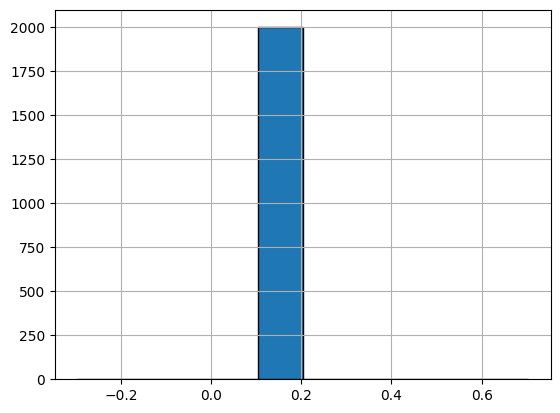

In [62]:
# посмотрим на распределение скора для Baseline:

test['Baseline'].hist(edgecolor = 'black')   

<Axes: >

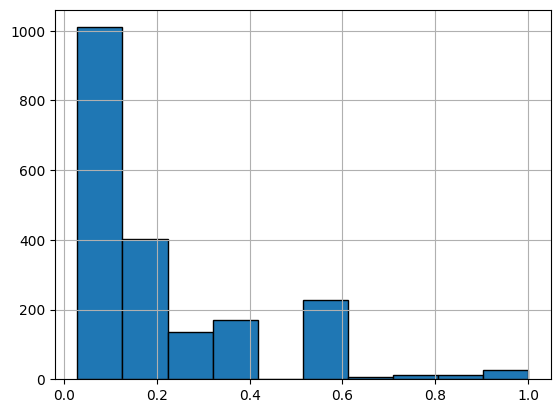

In [63]:
# посмотрим на распределение скора в человеческом обучении:

test['score_prod_age'].hist(edgecolor = 'black')

<Axes: >

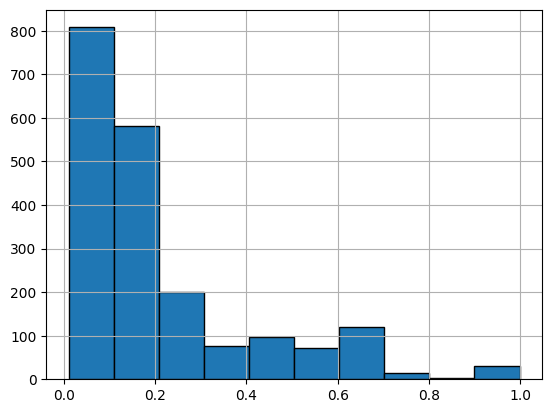

In [64]:
# посмотрим на распределение скора в машинном обучении для двух фичей:

test['machine_prod_age'].hist(edgecolor = 'black') 

<Axes: >

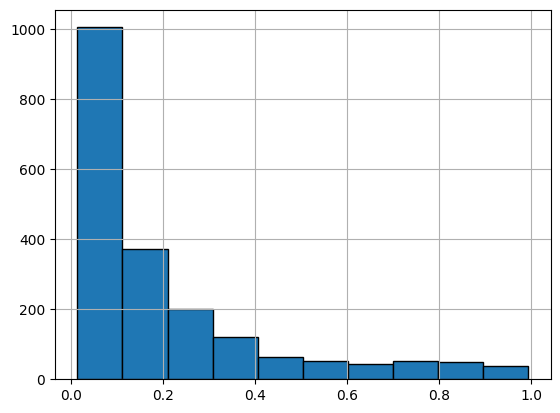

In [65]:
# посмотрим на распределение скора в машинном обучении для ВСЕХ фичей:

test['SCORE_ALL_FEATURES'].hist(edgecolor = 'black')

# PREDICT y_pred

In [66]:
# Предикт y_pred - с установленным порогом:

test['y_pred'] = test['SCORE_ALL_FEATURES'] > 0.5

In [67]:
# умножая bool на 1 получаем 1 или 0
print(True * 1, False * 1)

1 0


In [68]:
# чтобы в столбце test['y_pred'] значения были представлены не как "True и False", а как "0 и 1":
    
test['y_pred'] = (test['SCORE_ALL_FEATURES'] > 0.5)*1

In [69]:
test

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited,age_group,score_prod_age,machine_prod_age,Baseline,SCORE_ALL_FEATURES,y_pred
0,9168,15645353,Chubb,607,France,Male,26,1,0.00,1,1,0,29818.20,0,"(0, 31]",0.106774,0.097950,0.2035,0.135795,0
1,9388,15594576,Zhdanov,524,France,Male,32,1,144875.71,1,0,0,187740.04,0,"(31, 35]",0.135908,0.123485,0.2035,0.083274,0
2,6860,15811927,Marcelo,733,France,Female,38,3,157658.36,1,0,0,19658.43,0,"(35, 40]",0.198646,0.196776,0.2035,0.191387,0
3,3501,15675675,Slate,850,France,Female,32,5,106290.64,1,1,0,121982.73,0,"(31, 35]",0.135908,0.123485,0.2035,0.093775,0
4,6234,15682914,Bolton,850,France,Male,34,2,72079.71,1,1,1,115767.93,0,"(31, 35]",0.135908,0.137989,0.2035,0.067618,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,7393,15795079,Nnaife,596,Spain,Male,67,6,0.00,2,1,1,138350.74,0,"(46, 99]",0.225869,0.103882,0.2035,0.037178,0
1996,3234,15601550,Genovesi,595,Spain,Male,36,6,85768.42,1,1,1,24802.77,0,"(35, 40]",0.198646,0.164582,0.2035,0.104785,0
1997,219,15659366,Shih,807,France,Male,43,1,105799.32,2,1,0,34888.04,1,"(40, 46]",0.106239,0.124178,0.2035,0.191112,0
1998,4756,15740072,Padovesi,720,France,Female,37,2,120328.88,2,1,1,138470.21,0,"(35, 40]",0.059977,0.051863,0.2035,0.070693,0


In [70]:
# Теперь можно посчитать только еденицы - долю тех, кому мы предсказали отток:

test['y_pred'].mean()

0.1185

In [51]:
# теперь нужно научиться анализировать этот ответ:

# МАТРИЦА ОШИБОК

In [52]:
# матрица ошибок - главная вещь для анализа ответа классификатора

In [71]:
from sklearn.metrics import confusion_matrix

In [72]:
pd.DataFrame(confusion_matrix(test['Exited'], test['y_pred']))

,0,1
0,1541,52
1,222,185


In [73]:
tn, fp, fn, tp = confusion_matrix(test['Exited'], test['y_pred']).ravel()

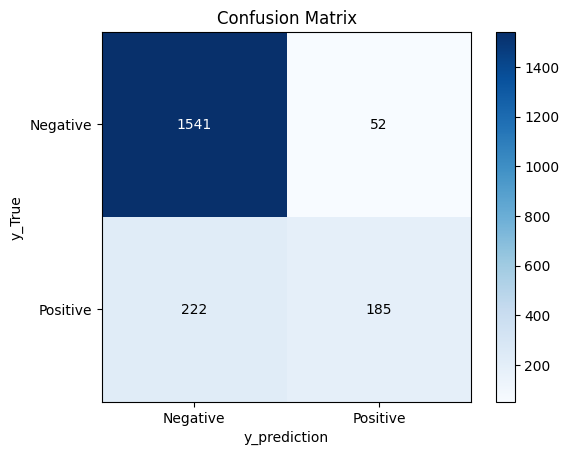

In [74]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

tn, fp, fn, tp = confusion_matrix(test['Exited'], test['y_pred']).ravel()

# Создание матрицы ошибок
confusion_matrix = np.array([[tn, fp], [fn, tp]])

# Настройка осей
classes = ['Negative', 'Positive']
ticks = np.arange(len(classes))

# Создание графика
plt.imshow(confusion_matrix, cmap='Blues')

# Добавление текста к ячейкам
thresh = confusion_matrix.max() / 2
for i in range(confusion_matrix.shape[0]):
    for j in range(confusion_matrix.shape[1]):
        plt.text(j, i, format(confusion_matrix[i, j], 'd'),
                 ha="center", va="center",
                 color="white" if confusion_matrix[i, j] > thresh else "black")

# Настройка осей и заголовка
plt.xticks(ticks, classes)
plt.yticks(ticks, classes)
plt.xlabel('y_prediction')
plt.ylabel('y_True')
plt.title('Confusion Matrix')

# Отображение цветовой шкалы
plt.colorbar()

# Показать график
plt.show()

In [58]:
# from sklearn.metrics import ConfusionMatrixDisplay
# confmetrx = ConfusionMatrixDisplay(confusion_matrix(test['Exited'], test['y_pred']))
# confmetrx.plot()

In [ ]:
#     Если y_True и y_prediction совпадают - значит TRUE
    
#     Если y_True и y_prediction НЕ совпадают - значит FALSE


# Чтобы определить POSITIVE или NEGATIVE смотрим на y_prediction:

#     Если TRUE:
# Если y_prediction = Positive и y_True = Positive - значит TRUE POSITIVE
# Если y_prediction = Negative и y_True = Negative - значит TRUE NEGATIVE

#     Если FALSE:
# Если y_prediction = Positive и y_True = Negative - значит FALSE POSITIVE - ложное срабатываение - ошибка I рода
# Если y_prediction = Negative и y_True = Positive - значит TRUE NEGATIVE - ложный пропуск - ошибка II рода

# Все основные метрики считаются на основе матрицы ошибок confusion_matrix

https://en.wikipedia.org/wiki/Receiver_operating_characteristic

## Recall (полнота)
sensitivity, recall, hit rate, or true positive rate (TPR)

In [ ]:
# Recall - это процент 'единичек', которые модель пометила как 'единички'

# Эта метрика показывает насколько хорошо эта метрика умеет подсвечивать 'единички'

# В случае оттока клиентов - насколько хорошо она может подсветить отточного клиента

# В случае с сигналом - насколько хорошо она может подсвечивать сигнал

# tn, fp, fn, tp
# Формула: TPR = tp / P = tp / (tp + fn)

# !!! ПОКАЗЫВАЕТ ПРОЦЕНТ ВСЕХ НАСТОЯЩИХ ЕДИНИЧЕК, ПОМЕЧЕННЫХ ЕДИНИЧКАМИ - рассматриваем все единицы из y_TRUE

In [75]:
recall = tp / (tp + fn)
recall

0.45454545454545453

In [76]:
# или по-другому:

from sklearn.metrics import recall_score

recall_score(test['Exited'], test['y_pred'])

0.45454545454545453

In [ ]:
# одного recall недостаточно для оценки качества модели

## Precision (точность)

In [ ]:
# Precision - показывает процент правильных 'единичек', среди всех предсказанных 'единичек'

# !!! ПОКАЗЫВАЕТ ПРОЦЕНТ ВСЕХ ПРЕДСКАЗАННЫХ ЕДИНИЧЕК - рассматриваем все единицы из y_pred (tp + fp)

In [77]:
precision = tp/(tp + fp)
precision

# если нашей модели показывать и отточников и не отточников, то
# среди тех, кто отмечен как отточник - будет 77% реальных отточников

0.7805907172995781

In [78]:
# или по-другому:

from sklearn.metrics import precision_score

precision_score(test['Exited'], test['y_pred'])

0.7805907172995781

In [ ]:
# Precision у этой модели лучше чем Recall - это означает что:

# Проценты Precision говорят о том что такой процент из помеченных моделью как "1" будут действительно "1"

# Проценты Recall говорят о том что, такой процент из реальных "1" будут помечены моделью как "1"

### Пример Recall и Precision на кошках и ребенке

Учим ребенка опредеялть животное. Если кошка - говорит "мяу", если не кошка - молчит.

Задача бинарной классификации, ребенок - модель, классификатор.

Recall

Показали 100 картинок с кошкой. Только 80 сказал "мяу". Recall == 80/100 == 0.8 == 80%


Precision

Показываем 100 картинок не только с кошкой, но и с другими животными.

Сказано "мяу" 50 раз. Взяли эти 50 картинок на которые сказано "мяу" и оказалось что только на 20 из них есть кошка.

Значит Precision ребенка 20/50 == 0.4 == 40% 

Значит из тех 50 "Мяу" тоьлко 40% оказались кошкой на самом деле.

### С помощью двух этих метрик Recall и Precision уже можно оценивать работу классификатора

Одного Recall недостаточно, также как и одного Precision.

Но с помощью этих двух метрик уже можно говорить на сколько хорошо решаются задачи классификатора.

## Метрика F1
Объединяет в себе Recall и Precision

In [64]:
f1 = (2 * recall * precision) / (recall + precision)
f1

0.5793528505392913

In [ ]:
# метрика f1 - находится в диапазоне от 0 до 1 и чем больше, тем лучше.

In [65]:
from sklearn.metrics import f1_score

f1_score(test['Exited'], test['y_pred'])

0.5793528505392913

In [ ]:
# ### Общая функция sklearn для расчета любого f-score:

# from sklearn.metrics import fbeta_score
 
# fbeta_score(test['Exited'], test['y_pred'], beta=1)   # f1-score
 

# ### Под капотом:

# b = 1

# ((1 + b**2) * precision * recall) / (b**2 * precision + recall)

In [ ]:
# # f1 - является частным случаем F-метрики (F-Score)

# https://en.wikipedia.org/wiki/F-score
    
# # F1 показывает нам насколько Recall важнее чем Precision

# # 1 это вес, он может быть и другим (1 - это значение коэфф.бета в формуле F-Score)
# # когда бета == 1 это значит Recall и Precision одинаково значимы для нас


# # В зависимости от конкретной безнес задачи выставляется 2 (Recall важнее для нас чем precision) или 0.5 (Наоборот)



# ### КОГДА НАМ ВАЖЕН Recall ???

# Мы хотим сбивать все корабли пришельцев, но это также могут быть астеройды.
# Нам неважно сколько мы собъем астеройдов, главное чтобы были сбиты все корабли.
# Важно чтобы ни один корабль не прошел.
# Не важно сколько при этом уничтожено астеройдов.

# ### КОГДА НАМ ВАЖЕН Precision ???

# Мы должны назначить очень опасную операцию, и нам надо убедиться что она действительно необходима.
# Нам важно точно поставить диагноз.
# Поскольку операция опасная - нельзя отправлять всех пациентов на операционный стол без разбора.
# Нам важно чтобы на операцию попадали только те, кто точно в ней нуждается.
# Нам важен Precision


# Метрика Accuracy
Процент правильных ответов

#### ЭТУ МЕТРИКУ НЕЛЬЗЯ ИСПОЛЬЗОВАТЬ КОГДА У НАС НЕ СБАЛАНСИРОВАННЫЕ КЛАССЫ
#### А это часто бывает

In [ ]:
# несбалансированный класс - это когда доля одного ответа  в данных значительно больше доли другого

# когда например у нас 1000 наблюдений и из них только 50 единичек и 950 ноликов

# В целом, когда не 50% на 50% то уже несбалансированные). 
# Поэтому классы всегда на практике несбалансированные). 
# Ну особо еще выделяют сильный дисбаланс, т.е когда скажем 
# 30 на 70 или больше. А например 55 на 45 можно считать почти сбалансированными. 

# как экстремальный пример можно привести задачу предсказания доли кликнувших по 
# кнопке на странице сайта, эта доля может быть очень низка - 1 клик на несколько 
# сотен, если не тысяч посещений страницы. Поэтому если модель предскажет, что 
# никто не кликнул - accuracy всё-равно будет очень высоким

In [66]:
# там где модель назначила правильный класс - будет True, там где - не правильный - будет False:

test['Exited'] == test['y_pred']

0        True
1        True
2        True
3        True
4        True
        ...  
1995     True
1996     True
1997    False
1998     True
1999     True
Length: 2000, dtype: bool

In [67]:
# чтобы понять процент правильных ответов - Accuracy:

(test['Exited'] == test['y_pred']).mean()

0.8635

In [68]:
# или с помощью матрицы ошибок:

(tn + tp) / (tn + tp + fn + fp)

0.8635

In [69]:
# или с помощью sklearn:

from sklearn.metrics import accuracy_score

accuracy_score(test['Exited'], test['y_pred'])

0.8635

In [70]:
# нули и единицы распределены по выборке не 50% на 50%:

# доля единиц в нашем случае 20%, доля нулей 80%

# это не сбалансированный класс:

test['Exited'].mean()

# ЭТУ МЕТРИКУ НЕЛЬЗЯ ИСПОЛЬЗОВАТЬ КОГДА У НАС НЕ СБАЛАНСИРОВАННЫЕ КЛАССЫ

0.2035

# Classification report

In [71]:
from sklearn.metrics import classification_report

In [72]:
print(classification_report(test['Exited'], test['y_pred']))

              precision    recall  f1-score   support

           0       0.88      0.97      0.92      1593
           1       0.78      0.46      0.58       407

    accuracy                           0.86      2000
   macro avg       0.83      0.71      0.75      2000
weighted avg       0.86      0.86      0.85      2000



In [73]:
# выше мы считали для класса еденичек:

print(recall)
print(precision)
print(f1)

0.4619164619164619
0.7768595041322314
0.5793528505392913


# ВСЕ ЭТИ МЕТРИКИ ПОСЧИТАНЫ ВСЕГО ЛИШЬ ДЛЯ ОДНОГО ПОРОГА, КОТОРЫЙ МЫ ЗАДАЛИ

In [ ]:


# # Предикт y_pred - с установленным порогом:

# test['y_pred'] = test['SCORE_ALL_FEATURES'] > 0.5

# Это тот порог с помощью которого мы преобразовали наш SCORE в нолики или единицы

# Но мы можем выбрать любой порог вместо 0.5 - любой порог в диапазоне от 0 до единицы



In [74]:
# например сделаем порог в 0.4

test['y_pred'] = test['SCORE_ALL_FEATURES'] > 0.4

In [75]:
# выводым classification_report для порога 0.4:

# classification_report и значения recall, precision - для этого порога - другие, чем для 0.5:

print(classification_report(test['Exited'], test['y_pred']))

              precision    recall  f1-score   support

           0       0.89      0.94      0.92      1593
           1       0.71      0.55      0.62       407

    accuracy                           0.86      2000
   macro avg       0.80      0.75      0.77      2000
weighted avg       0.86      0.86      0.86      2000



In [ ]:
# Нас интересует максимальный f1 - при каком пороге f1 - максимальный???

# Для того, чтобы найти максимальный f1 надо взять все пороги и посчитать для них f1, выбрать максимальный

# Бесконечное количество порогов перебирать не надо:


# Необходимо перебрать только количество уникальных скоров

# И еще нужно добавить порог, при котором все значения будут классифицированы как единица. 
# Например добавлением искусственно нуля в начало скора


In [76]:
# Посчитаем f1 для всех возможных порогов и найдем порог с максимальным f1:


test['SCORE_ALL_FEATURES']

0       0.117387
1       0.069690
2       0.169110
3       0.089905
4       0.062131
          ...   
1995    0.026964
1996    0.102691
1997    0.176148
1998    0.066283
1999    0.058493
Name: SCORE_ALL_FEATURES, Length: 2000, dtype: float64

In [77]:
# количество уникальных скоров:

test['SCORE_ALL_FEATURES'].nunique()

2000

In [78]:
# thrs - сокращение от thresholds - переменная содержащая все пороги

thrs = list(test['SCORE_ALL_FEATURES'].unique())

In [79]:
# выведем первые 10 возможных порогов (из 2000 в данном случае):

thrs[:10]

[0.11738709825258084,
 0.0696899683335773,
 0.16910957639629676,
 0.08990490897318036,
 0.06213052149758565,
 0.06769608755703861,
 0.5314062142371105,
 0.230024897124664,
 0.053961966815553576,
 0.39303486705191054]

In [80]:
# и еще нужно вывести пороги, при которых все значения скора получат метку "1":

# минимальный порог:
min(thrs)

0.010188542527368925

In [92]:
# добавим значение еще меньше минимального порога - тогда все значения score получат метки "1":

thrs = [0] + list(test['SCORE_ALL_FEATURES'].unique())

In [93]:
thrs[:10]

[0,
 0.11738709825258084,
 0.0696899683335773,
 0.16910957639629676,
 0.08990490897318036,
 0.06213052149758565,
 0.06769608755703861,
 0.5314062142371105,
 0.230024897124664,
 0.053961966815553576]

In [ ]:
# Крутая шткуа для визуализации процесса выполнения:

from tqdm import tqdm
import time

# Create a list
my_list = range(100)

# Wrap the list with tqdm
for item in tqdm(my_list):
    # Simulate some work
    time.sleep(0.1)


In [130]:
# И ее модификация чтобы шкала была зеленой:
    
from tqdm import tqdm
import time

# Create a list
my_list = range(100)

# Wrap the list with tqdm and set bar_format
for item in tqdm(my_list, colour='green'):
    # Simulate some work
    time.sleep(0.1)


100%|████████████████████████████████████████████████████████████████████████████████| 100/100 [00:10<00:00,  9.19it/s]


In [133]:
from sklearn.metrics import f1_score

# для визуализации длительного процесса вычислений - выведем прогресс-бар:

from tqdm import tqdm

# теперь есть все пороги для которых нужно посчитать f1:

# создаем массив в котором будем хранить все f1:
result = []

# для каждого порога делаем предикт в столбце y_pred_new:
# чтобы получить прогресс-бар надо завернуть в tqdm тот спискок - по которому мы идем циклом:

for i in tqdm(thrs):
    test['y_pred_new'] = (test['SCORE_ALL_FEATURES'] > i) * 1
    
    # для каждого порога считаем f1:    
    # добавляем в спискок:
    # добавляем кортеж из i - это значение порога, и f1)
    result.append((i, f1_score(test['Exited'], test['y_pred_new'])))
    
    
    

100%|█████████████████████████████████████████████████████████████████████████████| 2001/2001 [00:03<00:00, 518.92it/s]


In [105]:
len(result)

2001

In [106]:
result[:10]

[(0, 0.3381803074366431),
 (0.11738709825258084, 0.5358208955223881),
 (0.0696899683335773, 0.4610849056603773),
 (0.16910957639629676, 0.5800344234079174),
 (0.08990490897318036, 0.4947229551451187),
 (0.06213052149758565, 0.4451977401129943),
 (0.06769608755703861, 0.4575087310826542),
 (0.5314062142371105, 0.5624012638230648),
 (0.230024897124664, 0.6179196704428424),
 (0.053961966815553576, 0.42512077294685985)]

In [118]:
# найдем максимальный f1:

pd.DataFrame(result, columns = ['Порог', 'f1']).sort_values(by='f1', ascending = False)

,Порог,f1
1755,0.321291,0.637363
363,0.315151,0.636804
989,0.320802,0.636585
902,0.314272,0.636034
1410,0.334712,0.635910
...,...,...
413,0.992000,0.019465
180,0.992096,0.014634
315,0.992903,0.009780
1205,0.993651,0.004902


In [119]:
# или по-другому:

t = pd.DataFrame(result, columns = ['Порог', 'f1'])

In [122]:
# через фильтрацию теперь находим максимум по f1:

t[t['f1'] == t['f1'].max()]

,Порог,f1
1755,0.321291,0.637363


# Receiver operating characteristics (ROC)

In [138]:
from sklearn.metrics import roc_curve

In [141]:
# FalsePositiveRates, TruePositives, Threshholds
fprs, tprs, thrs =  roc_curve(test['Exited'], test['SCORE_ALL_FEATURES'])

In [143]:
roc = pd.DataFrame({'fpr': fprs, 'tpr': tprs, 'thr': thrs})

In [144]:
# здесь задается максимальный порог 1.99, вместо того чтобы задать минимальный порог [0], как мы делали выше:
roc

,fpr,tpr,thr
0,0.000000,0.000000,1.995549
1,0.000000,0.002457,0.995549
2,0.000000,0.061425,0.931912
3,0.000628,0.061425,0.931077
4,0.000628,0.115479,0.894426
...,...,...,...
397,0.976146,0.995086,0.014253
398,0.976146,0.997543,0.014134
399,0.988073,0.997543,0.012587
400,0.988073,1.000000,0.012331


<Axes: xlabel='fpr'>

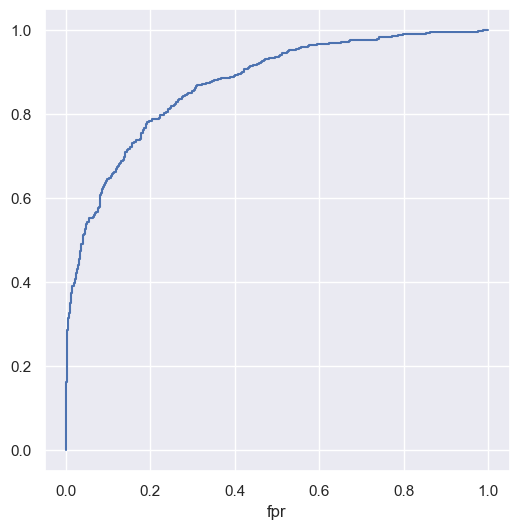

In [158]:
# строим график ROC кривой:

roc.set_index('fpr')['tpr'].plot(figsize = (6,6))

<Axes: xlabel='fpr'>

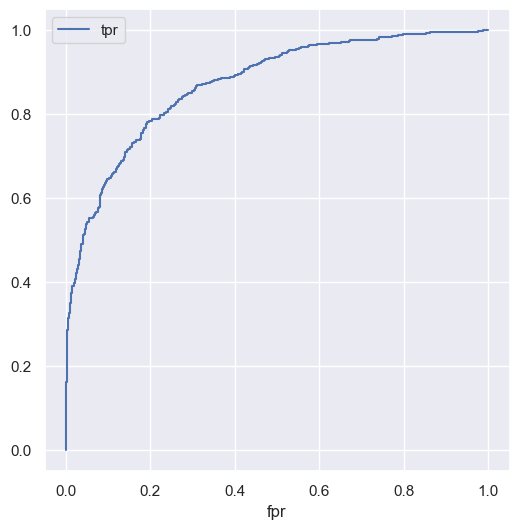

In [160]:
# чтобы добавить идеальную модель и случайную модель построим график немного по-другому:

roc.plot(x = 'fpr', y = 'tpr', figsize = (6,6))

In [161]:
# теперь сделаем случайную модель:
# задаем колонку random в которую передается тот же столбец что и по "x", чтобы получилась диагональ.

roc['random'] = roc['fpr']

<Axes: xlabel='fpr'>

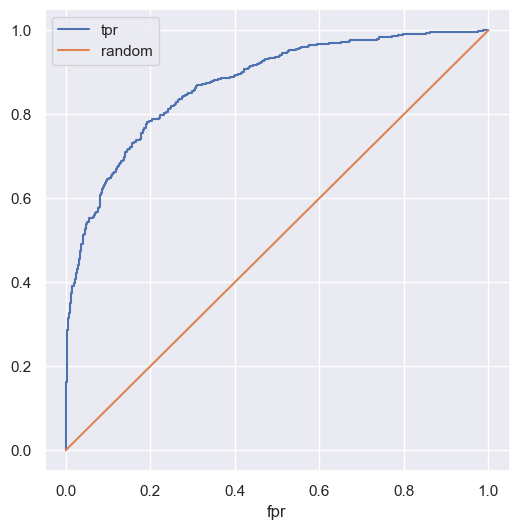

In [162]:
roc.plot(x = 'fpr', y = ['tpr', 'random'], figsize = (6,6))

<Axes: xlabel='fpr'>

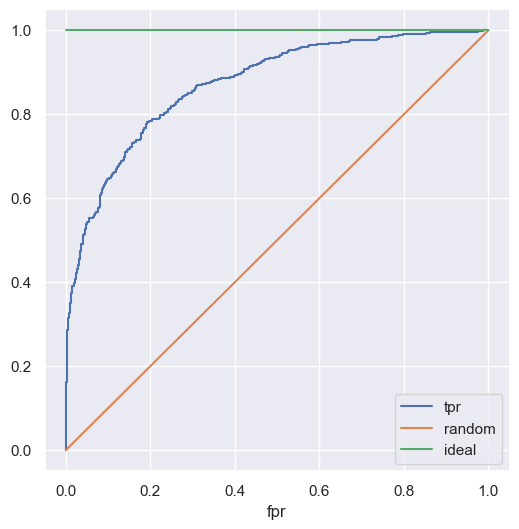

In [164]:
# еще добавим идеальную модель - где все единицы - всегда оказываются единицами, а все нули - всегда на нуле:

roc['ideal'] = 1
roc.plot(x = 'fpr', y = ['tpr', 'random', 'ideal'], figsize = (6,6))

In [ ]:
# или воспользовавшись кодом:
# https://stackoverflow.com/questions/25009284/how-to-plot-roc-curve-in-python

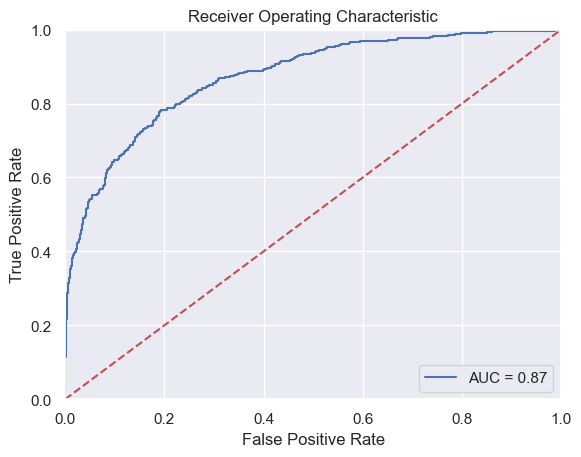

In [165]:
import sklearn.metrics as metrics


# calculate the fpr and tpr for all thresholds of the classification
# probs = model.predict_proba(X_test) - это уже у нас есть
# preds = probs[:,1] - и это тоже

fpr, tpr, threshold = metrics.roc_curve(test['Exited'], test['SCORE_ALL_FEATURES'])


roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [166]:
# также ROC кривую можно построить из catboost

# from catboost.utils import get_roc_curve

In [175]:
# test_data = Pool(data=test[X],
#                   label=test[y],
#                   cat_features=cat_features
#                  )

In [179]:
# получаем три массива на которых можно построить ROC кривую:
# get_roc_curve(model_1, test_data)

In [180]:
# или сразу строим ROC кривую:
# в конце ставим ; чтобы не выводились массивы чисел
# get_roc_curve(model_1, test_data, plot = True);

# AUC

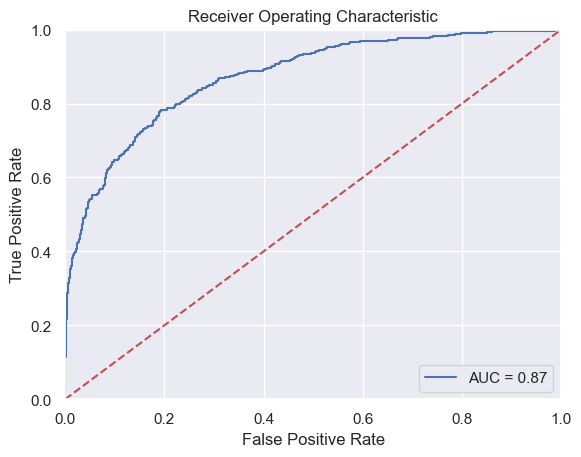

In [181]:
import sklearn.metrics as metrics


# calculate the fpr and tpr for all thresholds of the classification
# probs = model.predict_proba(X_test) - это уже у нас есть
# preds = probs[:,1] - и это тоже

fpr, tpr, threshold = metrics.roc_curve(test['Exited'], test['SCORE_ALL_FEATURES'])


roc_auc = metrics.auc(fpr, tpr)

# method I: plt
import matplotlib.pyplot as plt
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()


In [ ]:
# AUC - это площадь под графиком. Если модель идеальная - площадь равна 1, рандом = 0.5
# т.о. чем больше AUC - тем лучше модель

In [183]:
from sklearn.metrics import roc_auc_score

In [184]:
roc_auc_score(test['Exited'], test['SCORE_ALL_FEATURES'])

0.8722204484916349

# ROC AUC при сильно несбалансированных классах

In [ ]:
# В СЛУЧАЯХ КОГДА ВАЖЕН FALSE POSITIVE RATE

In [190]:
t = pd.DataFrame({'y_true': [0] * 990 + [1] * 10})

In [191]:
t['y_true'].mean()

0.01

In [196]:
# создаем несоклько искусственных скоров, которые будут представлять из себя скоры какой-то модели:

# этот скор будет склонять модель что скорее y_true - это ноль:
np.random.uniform(0, 0.2)

# а этот скор будет склонять модель что скорее y_true - это единица:
np.random.uniform(0.8, 1)

# чтобы создать замешанный совместный скор - воспользуемся конкатенацией:

np.concatenate([np.random.uniform(0, 0.2, size = 2), np.random.uniform(0.8, 1, size = 3)])


array([0.08679511, 0.01174707, 0.86765836, 0.99385139, 0.87874364])

In [ ]:
t = pd.DataFrame({'y_true': [0] * 990 + [1] * 10})

In [203]:
# создаем первый скор где для 990 реальных нулей будет 970 ближе к нулям и 20 ближе к единице,
# а также для 10 реальных единиц будет 5 ближе к нулям и 5 ближе к единице:

np.random.seed(42)
t['y_score_1'] = np.concatenate([np.random.uniform(0, 0.2, size = 970), 
                                 np.random.uniform(0.8, 1, size = 20),
                                np.random.uniform(0, 0.2, size = 5),
                                np.random.uniform(0.8, 1, size = 5)]
                               )

In [204]:
t

,y_true,y_score_1
0,0,0.074908
1,0,0.190143
2,0,0.146399
3,0,0.119732
4,0,0.031204
...,...,...
995,1,0.818316
996,1,0.983463
997,1,0.827364
998,1,0.990047


In [205]:
# рассчитаем AUC для первого скора:

roc_auc_score(t['y_true'], t['y_score_1'])

0.7664646464646465

In [206]:
# теперь создадим второй скор:

np.random.seed(42)
t['y_score_2'] = np.concatenate([np.random.uniform(0, 0.2, size = 930), 
                                 np.random.uniform(0.8, 1, size = 60),
                                np.random.uniform(0, 0.2, size = 2),
                                np.random.uniform(0.8, 1, size = 8)]
                               )

In [207]:
# рассчитаем AUC для второго скора:

roc_auc_score(t['y_true'], t['y_score_2'])

0.9166666666666667

# Precision Recall curve

In [ ]:
# https://machinelearningmastery.com/roc-curves-and-precision-recall-curves-for-classification-in-python/

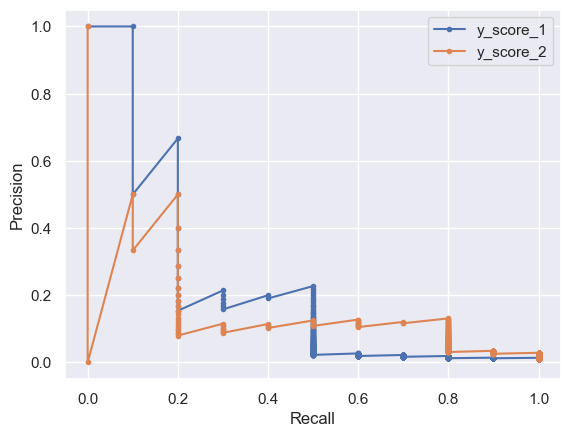

In [211]:
# здесь мы смотрим зависимость Precision от Recall

# каждая точка здесь это порог. при увеличении Recall - падает Precision 

# здесь можно выбрать лучшую модель
# какая кривая выше - та и лучше

# precision-recall curve and f1
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score
from sklearn.metrics import auc
from matplotlib import pyplot


precision_1, recall_1, _ = precision_recall_curve(t['y_true'], t['y_score_1'])
precision_2, recall_2, _ = precision_recall_curve(t['y_true'], t['y_score_2'])


pyplot.plot(recall_1, precision_1, marker='.', label='y_score_1')
pyplot.plot(recall_2, precision_2, marker='.', label='y_score_2')


# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [213]:
# метрика average Precision отражает площадь под кривой:

from sklearn.metrics import average_precision_score

print(average_precision_score(t['y_true'], t['y_score_1']))
print(average_precision_score(t['y_true'], t['y_score_2']))

0.2404742335681647
0.1797651767227378


# Сравним человеческое и машинное обучение

In [214]:
test

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,...,IsActiveMember,EstimatedSalary,Exited,age_group,score_prod_age,machine_prod_age,Baseline,SCORE_ALL_FEATURES,y_pred,y_pred_new
0,9168,15645353,Chubb,607,France,Male,26,1,0.00,1,...,0,29818.20,0,"(0, 31]",0.106774,0.097950,0.2035,0.117387,False,1
1,9388,15594576,Zhdanov,524,France,Male,32,1,144875.71,1,...,0,187740.04,0,"(31, 35]",0.135908,0.123485,0.2035,0.069690,False,1
2,6860,15811927,Marcelo,733,France,Female,38,3,157658.36,1,...,0,19658.43,0,"(35, 40]",0.198646,0.196776,0.2035,0.169110,False,1
3,3501,15675675,Slate,850,France,Female,32,5,106290.64,1,...,0,121982.73,0,"(31, 35]",0.135908,0.123485,0.2035,0.089905,False,1
4,6234,15682914,Bolton,850,France,Male,34,2,72079.71,1,...,1,115767.93,0,"(31, 35]",0.135908,0.137989,0.2035,0.062131,False,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1995,7393,15795079,Nnaife,596,Spain,Male,67,6,0.00,2,...,1,138350.74,0,"(46, 99]",0.225869,0.103882,0.2035,0.026964,False,0
1996,3234,15601550,Genovesi,595,Spain,Male,36,6,85768.42,1,...,1,24802.77,0,"(35, 40]",0.198646,0.164582,0.2035,0.102691,False,1
1997,219,15659366,Shih,807,France,Male,43,1,105799.32,2,...,0,34888.04,1,"(40, 46]",0.106239,0.124178,0.2035,0.176148,False,1
1998,4756,15740072,Padovesi,720,France,Female,37,2,120328.88,2,...,1,138470.21,0,"(35, 40]",0.059977,0.051863,0.2035,0.066283,False,1


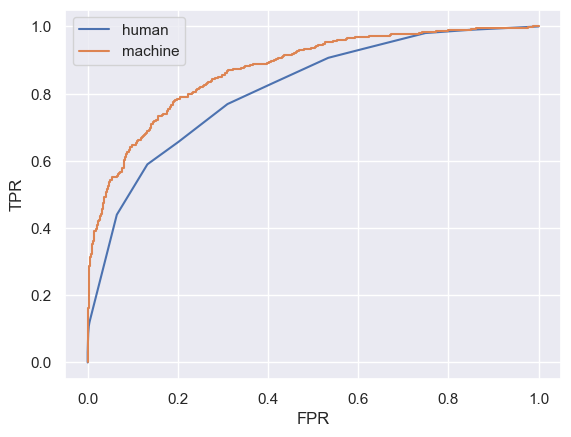

In [220]:
fpr1, tpr_1, _ = roc_curve(test['Exited'], test['score_prod_age'])
fpr2, tpr_2, _ = roc_curve(test['Exited'], test['SCORE_ALL_FEATURES'])


pyplot.plot(fpr1, tpr_1, label='human')
pyplot.plot(fpr2, tpr_2, label='machine')


# axis labels
pyplot.xlabel('FPR')
pyplot.ylabel('TPR')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [223]:
print('human', roc_auc_score(test['Exited'], test['score_prod_age']))
print('machine', roc_auc_score(test['Exited'], test['SCORE_ALL_FEATURES']))

human 0.8119961255554475
machine 0.8722204484916349


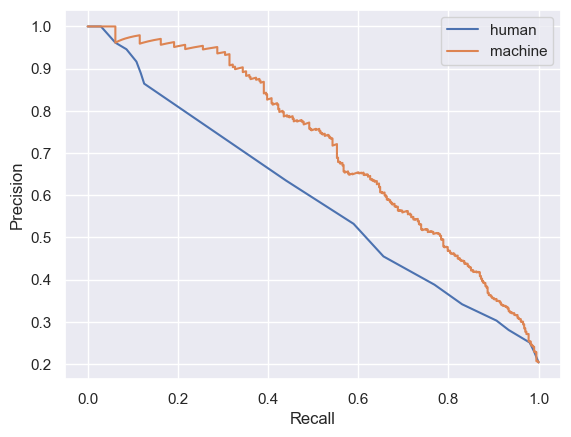

In [225]:
precision_1, recall_1, _ = precision_recall_curve(test['Exited'], test['score_prod_age'])
precision_2, recall_2, _ = precision_recall_curve(test['Exited'], test['SCORE_ALL_FEATURES'])


pyplot.plot(recall_1, precision_1, label='human')
pyplot.plot(recall_2, precision_2, label='machine')


# axis labels
pyplot.xlabel('Recall')
pyplot.ylabel('Precision')
# show the legend
pyplot.legend()
# show the plot
pyplot.show()

In [226]:
print('human', average_precision_score(test['Exited'], test['score_prod_age']))
print('machine', average_precision_score(test['Exited'], test['SCORE_ALL_FEATURES']))

human 0.5397719144338842
machine 0.7145308087956946
